This is code for running PR1 FED3 analyses relying on the [FED3](https://earnestt1234.github.io/fed3/fed3/index.html) library written by Tom Earnest.

It will import a folder of FED3 files, crop them by time, group them, and make plots for total pellets, pokes, pokes/pellet, accuracy, etc.

NOTE: the FED3 library will need to be installed (Step 0)

## Step 0: Install FED3 library

In [1]:
!pip install git+https://github.com/earnestt1234/fed3.git -q fed3

  Preparing metadata (setup.py) ... done


In [31]:
#%% import libraries and set plot parameters
import fed3
import fed3.plot as fplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import os
import io
from google.colab import files
import warnings
warnings.filterwarnings('ignore')  # this is a bit dangerous but we'll supress warnings

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Step 1: Import data

Saving FNaive_167_FED008_122024_72h.csv to FNaive_167_FED008_122024_72h (1).csv
Saving FNaive_167a_FED005_122024_72h.csv to FNaive_167a_FED005_122024_72h (1).csv
Saving FNaive_167b_FED011_122024_72h.csv to FNaive_167b_FED011_122024_72h (1).csv
Saving FNaive_170_FED002_122024_72h.csv to FNaive_170_FED002_122024_72h (1).csv
Loaded 4 files: ['FNaive_167_FED008_122024_72h (1).csv', 'FNaive_167a_FED005_122024_72h (1).csv', 'FNaive_167b_FED011_122024_72h (1).csv', 'FNaive_170_FED002_122024_72h (1).csv']


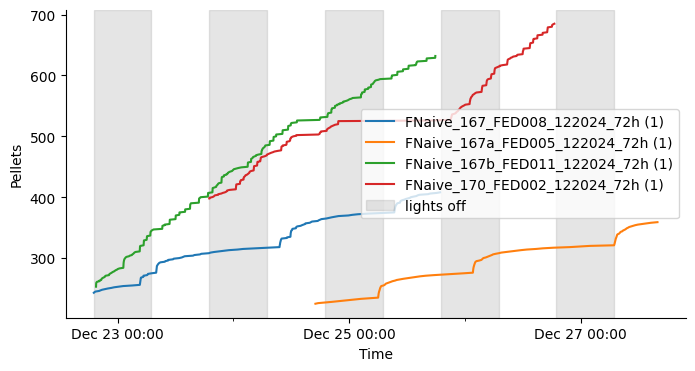

In [80]:
# Upload multiple files
uploaded = files.upload()

# List of loaded FED3 files, only including files > 1KB
feds = [fed3.load(file) for file, data in uploaded.items() if len(data) > 1024]

# Proceed if any files were loaded
if feds:
    fed3.as_aligned(feds, alignment="datetime", inplace=True)

    # Print loaded file names
    loaded_files = [file for file, data in uploaded.items() if len(data) > 1024]
    print(f"Loaded {len(feds)} files: {loaded_files}")

    # Plot raw data
    plt.figure(figsize=(8, 4))
    fplot.line(feds, y='pellets')
    plt.show()
else:
    print("No valid files loaded.")

## Representative Example

Text(0.5, 0.98, 'FNaive_167b_FED011_122024_72h (1).csv')

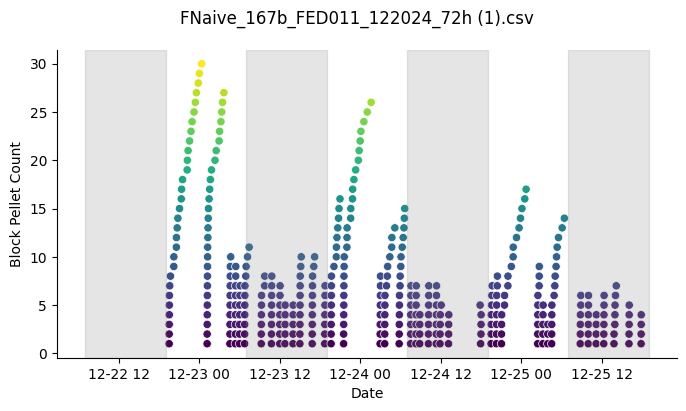

In [82]:
#Specify which file you want to plot by position in the import list
file = 2

# Filter data for "Pellet" events
pellet_df = feds[file][feds[file]['Event'] == 'Pellet']

# Create the figure
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data = pellet_df,
    x = pellet_df.index,
    y = pellet_df['Block_Pellet_Count'],
    c = pellet_df['Block_Pellet_Count'].clip(upper=40),
    cmap='viridis'
)

# Add shading for specified dark cycle
start_time, end_time = pd.to_datetime(['07:00:00', '19:00:00']).time
for day in pd.date_range(pellet_df.index.min().date(), pellet_df.index.max().date()):
    plt.axvspan(pd.Timestamp.combine(day, start_time), pd.Timestamp.combine(day, end_time), color='gray', alpha=0.2)

# Label the axes
plt.ylabel('Block Pellet Count')
plt.xlabel('Date')

# Set a title
filenames = list(uploaded.keys())
plt.suptitle(filenames[file])


## Align data if needed

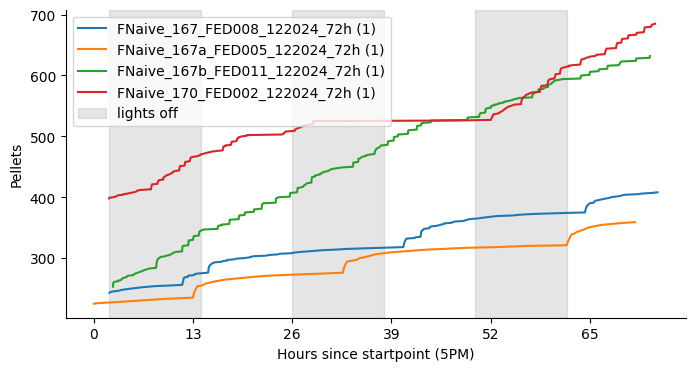

In [83]:
fed3.as_aligned(feds, alignment="time", inplace=True)
feds_cropped = feds #set this equal in case we don't crop
plt.figure(figsize=(8, 4))
fplot.line(feds, y='pellets')
plt.show()

## Step 2: Crop files to a defined time period (optional)

FEDFrame 0: Duration = 1 days 04:44:37
FEDFrame 1: Duration = 1 days 06:58:43
FEDFrame 2: Duration = 1 days 04:28:07
FEDFrame 3: Duration = 1 days 04:57:10


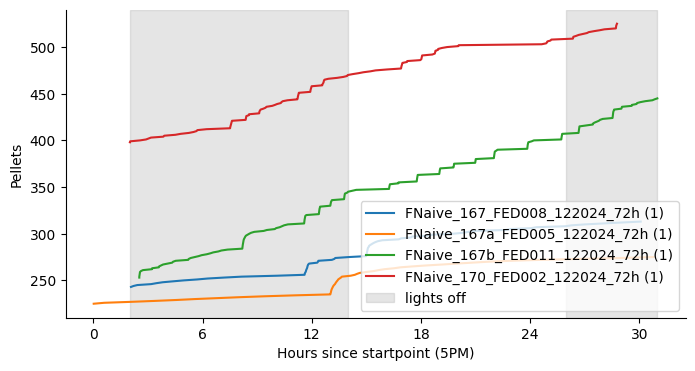

In [84]:
# Define start and end times - if you have aligned by "time" it will reset the "MM:DD:YY hh:mm:ss" column to "2000-01-01 0:00:00" so crop from there
start_time = "2000-01-01 0:00:00"
end_time = "2000-01-03 0:00:00"

# Apply timecrop to each FEDFrame in feds
feds_cropped = [fed3.timecrop(fed, start=start_time, end=end_time) for fed in feds]

# Print the duration of each cropped FEDFrame (Check that this appears accurate!)
for i, fed in enumerate(feds_cropped):
    print(f"FEDFrame {i}: Duration = {fed.duration}")

plt.figure(figsize=(8, 4))
fplot.line(feds_cropped, y='pellets')
plt.show()

## Step 3: Group data (optional)

In [87]:
grouped = {
    'Control': [feds_cropped[i] for i in [0, 1]],
    'Drug': [feds_cropped[i] for i in [2, 3]]
    #add more groups
}

## Step 4: Make plots using FED3 fplot functionality

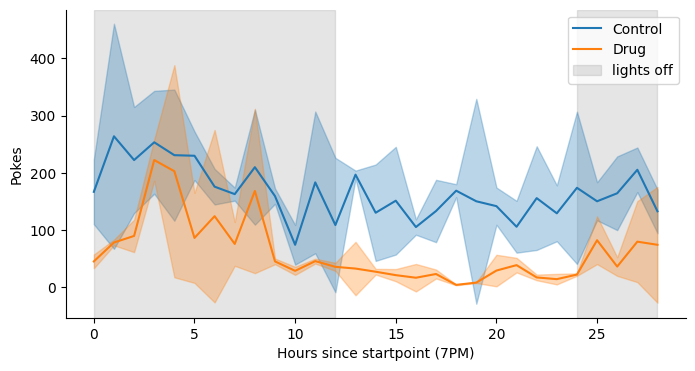

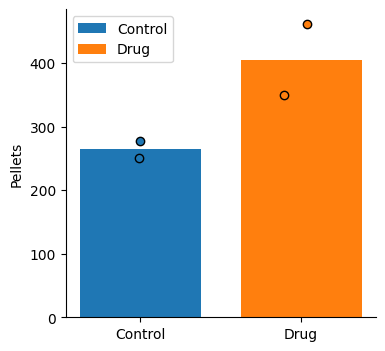

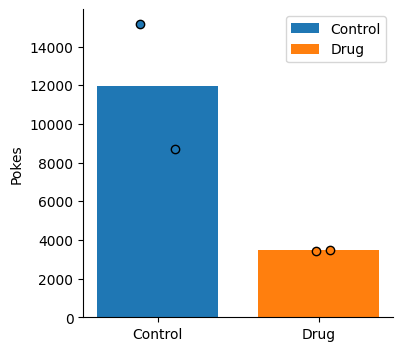

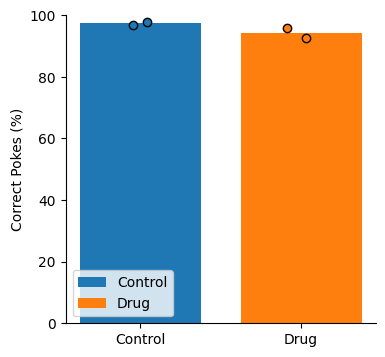

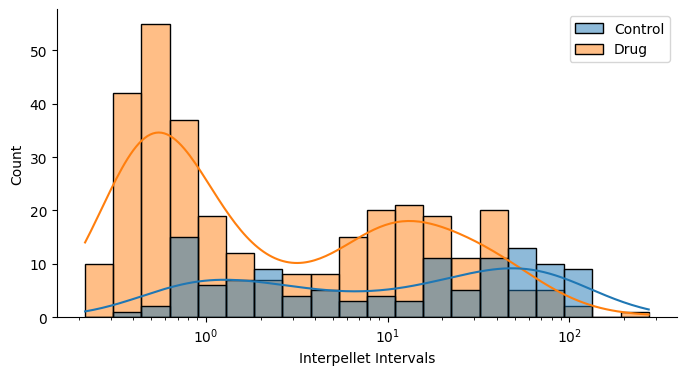

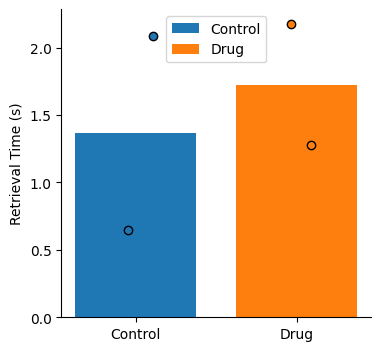

In [88]:
#%% compare line plot of pokes
plt.figure(figsize=(8, 4))
fplot.line(grouped, y='pokes', bins='1H')
plt.show()
print()

#%% Compare total pellets
fig = fplot.bar(grouped, y='pellets', stat='mean', var=None, show_individual=True)
plt.show()
print()

#%% Compare total pokes
fig = fplot.bar(grouped, y='pokes', stat='mean', var=None, show_individual=True)
plt.show()
print()

#%% Compare accuracy
fig = fplot.bar(grouped, y='cumulative_correct_percent', stat='mean', var=None, show_individual=True)
plt.ylim(0,100)
plt.show()
print()

#%% Compare inter-pellet-intervals
plt.figure(figsize=(8, 4))
fplot.ipi(grouped, logx=True, kde=True, bins = 20, mixed_align='raise', output='plot', ax=None, legend=None)
plt.show()
print()

#%% Compare retrieval times
fig = fplot.bar(grouped, y='rt', stat='mean', var=None, show_individual=True)
plt.show()



## Make custom plots that are not included in FED3 fplot

In [89]:
# Plot pokes/pellet (FED3.plot doesn't currently have this plot)

#%% Extract total pokes and pellets from each mouse
pokes = fplot.bar(feds, y='cumulative_pokes', stat='max', var=None, show_individual=True, output = "dataonly")
pellets = fplot.bar(feds, y='pellets', stat='max', var=None, show_individual=True, output = "dataonly")

#create pokesPerPellet metric
pokesPerPellet = pokes/pellets

# Create a mapping from identifier to group
id_to_group = {id_: group for group, ids in grouped.items() for id_ in ids}

# Apply the mapping to create a new column
pokesPerPellet['Group'] = pokesPerPellet.index.map(id_to_group)

# Define the palette
palette = ['#1f77b4', '#ff7f0e']

# Create a bar plot for mean values by group
bar = sns.barplot(x='Group', y='total.mean', data=df, ci=None, palette=palette)

# Add scatter points to show individual data, matching the color of the bars
groups = df['Group'].unique()
for i, group in enumerate(groups):
    # Filter the data for each group
    group_data = df[df['Group'] == group]
    # Scatter each point, using the same color as the corresponding bar
    plt.scatter([group]*len(group_data), 'total.mean', data=group_data, color=palette[i], edgecolor='black', s=50)

# Adding and positioning the legend
plt.legend(fontsize='11', labels=['Saline', 'Drug'])

# Enhancing the plot
plt.ylabel('Pokes/Pellet')
plt.xlabel('')
plt.grid(False)
sns.despine()

# Show the plot
plt.show()

TypeError: unhashable type: 'FEDFrame'